# Dog breed classification using PyTorch and AWS SageMAker

This notebook contains steps and code that make use of AWS SageMaker to finetune a pretrained RESNET50 pytorch model to perform image classification using images of dogs, classifying them according to their breeds. We will make use of SageMaker's Debugger to debug, monitor and profile the training job.

This notebook lists all the steps that you need to complete this project.

In [4]:
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import sagemaker
import boto3
import smdebug

## Dataset

The dataset used in this project is a labeled dataset of 8,351 real-world images of 133 American Kennel Club (AKC) recognized dog breeds. It is divided into 6680 images for training, 836 images for testing, 835 images for validation.  
The images in this dataset are of different sizes and backgrounds. The number of images provided for each breed varies, some breeds have fewer images than others.

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-25 13:35:41--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip        16%[==>                 ] 178.26M  46.6MB/s    eta 21s    ^C
Archive:  dogImages.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of dogImages.zip or
        dogImages.zip.zip, and cannot find dogImages.zip.ZIP, period.


In [6]:
# Upload the data to Amazon S3

import os
from sagemaker import get_execution_role

bucket= 'sagemaker-us-east-1-519574148523'
region = 'us-east-1'
role =  get_execution_role()
print("Default Bucket: {}".format(bucket))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/data/

Default Bucket: sagemaker-us-east-1-519574148523
AWS Region: us-east-1
RoleArn: arn:aws:iam::519574148523:role/service-role/AmazonSageMaker-ExecutionRole-20230209T103282


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [14]:
#Create estimators for your HPs
#Make sure the estimator is working properly before it is used to train with different hyperparameter values
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
		    entry_point='hpo.py',
            role=role,
            framework_version='1.8.1',
            py_version='py3',
            instance_count=1,
            instance_type='ml.m5.large',
		)
estimator.fit({'train': "s3://{}/data/".format(bucket)})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-02-27-10-26-22-467


2023-02-27 10:26:22 Starting - Starting the training job...
2023-02-27 10:26:38 Starting - Preparing the instances for training......
2023-02-27 10:27:26 Downloading - Downloading input data.........
2023-02-27 10:29:06 Training - Downloading the training image...
2023-02-27 10:29:32 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-27 10:29:35,573 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-27 10:29:35,578 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-27 10:29:35,595 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-27 10:29:35,604 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-27 10:29:35,895 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus inst

In [8]:
# Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

estimator = PyTorch.attach('pytorch-training-2023-02-27-10-26-22-467')


2023-02-27 10:45:07 Starting - Preparing the instances for training
2023-02-27 10:45:07 Downloading - Downloading input data
2023-02-27 10:45:07 Training - Training image download completed. Training in progress.
2023-02-27 10:45:07 Uploading - Uploading generated training model
2023-02-27 10:45:07 Completed - Training job completed


In [9]:

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [10]:
# Set certain OS variables
os.environ['SM_MODEL_DIR']='s3://{}/model/'.format(bucket)
os.environ['SM_CHANNEL_TRAIN']='s3://{}/data/'.format(bucket)
os.environ['SM_OUTPUT_DATA_DIR']='s3://{}/output/'.format(bucket)

In [11]:
# Fit your HP Tuner
tuner.fit({'train': "s3://{}/data/".format(bucket)},wait=True) 

...................................................................................................................................................................................................................................................!


In [12]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-03 03:11:40 Starting - Preparing the instances for training
2023-03-03 03:11:40 Downloading - Downloading input data
2023-03-03 03:11:40 Training - Training image download completed. Training in progress.
2023-03-03 03:11:40 Uploading - Uploading generated training model
2023-03-03 03:11:40 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'lr': '0.0013784972150508445',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-03-02-54-13-925"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-519574148523/pytorch-training-2023-02-27-10-26-22-467/source/sourcedir.tar.gz"'}

In [13]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['lr']}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [15]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8.1",
    py_version="py3",
    hyperparameters={'batch_size': 32, 'lr': '0.08277499248803206'},
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config, 
    rules=rules
)

estimator.fit({'train': "s3://{}/data/".format(bucket)},wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-03-03-17-46-295


2023-03-03 03:17:46 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-03-03 03:18:44 Starting - Preparing the instances for training...
2023-03-03 03:19:17 Downloading - Downloading input data............
2023-03-03 03:21:05 Training - Downloading the training image...............
2023-03-03 03:23:46 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-03 03:23:39,320 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-03 03:23:39,347 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-03 03:23:39,350 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-03 03:23:39,598 sagemaker-training-toolkit IN

In [16]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")

Training jobname: pytorch-training-2023-03-03-03-17-46-295


In [17]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))


[2023-03-03 03:26:43.991 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:228 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-03 03:26:44.024 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:228 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-519574148523/pytorch-training-2023-03-03-03-17-46-295/debug-output
[2023-03-03 03:26:45.742 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:228 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-03 03:26:46.762 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:228 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', '

In [18]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


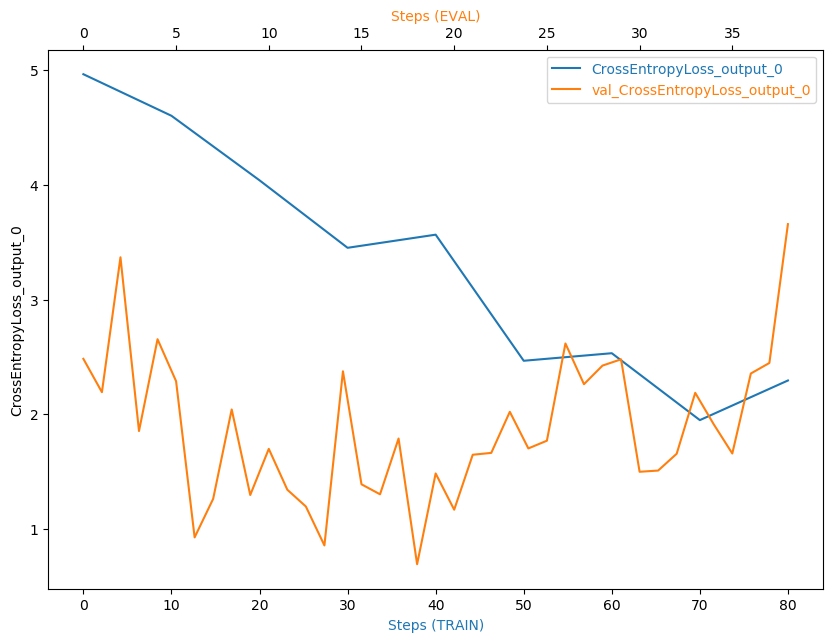

In [20]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [21]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(rule_output_path)

s3://sagemaker-us-east-1-519574148523/pytorch-training-2023-03-03-03-17-46-295/rule-output


In [22]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [23]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(100)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [24]:
# TODO: Display the profiler output
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

2023-03-03 03:25:27     379479 pytorch-training-2023-03-03-03-17-46-295/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-03 03:25:27     228732 pytorch-training-2023-03-03-03-17-46-295/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-03 03:25:22        191 pytorch-training-2023-03-03-03-17-46-295/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-03 03:25:22       4601 pytorch-training-2023-03-03-03-17-46-295/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-03 03:25:22       2253 pytorch-training-2023-03-03-03-17-46-295/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-03 03:25:22        129 pytorch-training-2023-03-03-03-17-46-295/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-03 03:25:22        782 pytorch-training-2023-03-03-03-17-46-295/rule-output/ProfilerReport/profiler-output/profiler-re

## Model Deploying

In [25]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
model_location='s3://sagemaker-us-east-1-519574148523/pytorch-training-2023-03-03-02-04-31-091/output/model.tar.gz'


In [26]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [27]:
# TODO: Deploy your model to an endpoint
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='model_endpoint.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)# TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-03-03-28-41-182
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-03-03-28-41-957
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-03-03-28-41-957


-

In [22]:
s3_client = boto3.client("s3")
filename="test_dog.jpg"
s3_client.download_file(
    bucket,
    "data/test/011.Australian_cattle_dog/Australian_cattle_dog_00734.jpg",
    filename,
)


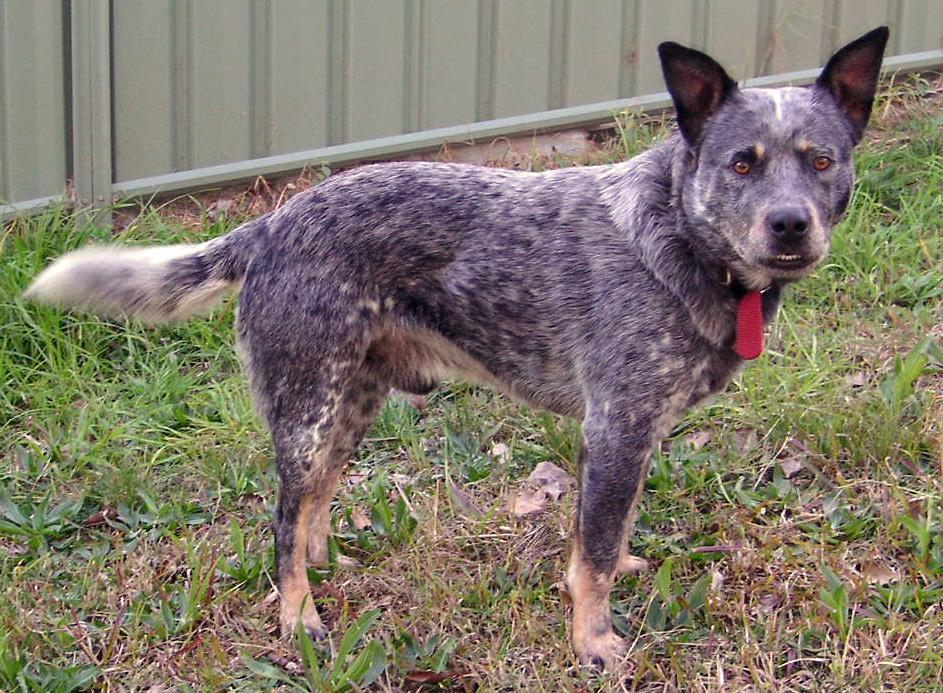

In [21]:
import io
from PIL import Image
with open(filename, "rb") as f:
    payload = f.read()
    
type(payload)

Image.open(io.BytesIO(payload))

In [ ]:

response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()